### Predicting and Analyzing Music Popularity Using Machine Learning ###

In [3]:
import pandas as pd
import zipfile
import os
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths
zip_files = {
    "features": "./features/musicoset_songfeatures.zip",
    "popularity": "./popularity/musicoset_popularity.zip",
    "metadata": "./metadata/musicoset_metadata.zip"
}

# locate the CSV files
features_file = "acoustic_features.csv"  # Replace with the correct file if needed
popularity_file = "song_pop.csv"         # Replace with the correct file if needed
metadata_file = "songs.csv"              # Replace with the correct file if needed

features_df = pd.read_csv("./features/musicoset_songfeatures/acoustic_features.csv", sep='\t')
popularity_df = pd.read_csv("./popularity/musicoset_popularity/song_pop.csv", sep='\t')
metadata_df = pd.read_csv("./metadata/musicoset_metadata/songs.csv", on_bad_lines='skip', sep='\t')

# Display the first few rows of each DataFrame
# print("Features DataFrame:")
# print(features_df.head())
# print("\nPopularity DataFrame:")
# print(popularity_df.head())
# print("\nMetadata DataFrame:")
# print(metadata_df.head())

In [4]:
# Check for missing values
print("Missing values in Features DataFrame:")
print(features_df.isnull().sum())
print("\nMissing values in Popularity DataFrame:")
print(popularity_df.isnull().sum())
print("\nMissing values in Metadata DataFrame:")
print(metadata_df.isnull().sum())

# Drop duplicates if any
features_df.drop_duplicates(inplace=True)
popularity_df.drop_duplicates(inplace=True)
metadata_df.drop_duplicates(inplace=True)

Missing values in Features DataFrame:
song_id             0
duration_ms         0
key                 0
mode                0
time_signature      0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
valence             0
tempo               0
dtype: int64

Missing values in Popularity DataFrame:
song_id           0
year_end_score    0
is_pop            0
year              0
dtype: int64

Missing values in Metadata DataFrame:
song_id       0
song_name     0
billboard     0
artists       0
popularity    0
explicit      0
song_type     0
dtype: int64


In [5]:
features_df.columns = features_df.columns.str.strip()
popularity_df.columns = popularity_df.columns.str.strip()
metadata_df.columns = metadata_df.columns.str.strip()
print("Features DataFrame Columns:", features_df.columns)
print("Popularity DataFrame Columns:", popularity_df.columns)
print("Metadata DataFrame Columns:", metadata_df.columns)

Features DataFrame Columns: Index(['song_id', 'duration_ms', 'key', 'mode', 'time_signature',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'valence', 'tempo'],
      dtype='object')
Popularity DataFrame Columns: Index(['song_id', 'year_end_score', 'is_pop', 'year'], dtype='object')
Metadata DataFrame Columns: Index(['song_id', 'song_name', 'billboard', 'artists', 'popularity',
       'explicit', 'song_type'],
      dtype='object')


In [6]:
# Merge datasets on a common key (e.g., 'song_id')
merged_df = features_df.merge(popularity_df, on="song_id").merge(metadata_df[['song_id', 'popularity']], on="song_id", how="left")

In [7]:
from sklearn.preprocessing import StandardScaler

# Drop rows with missing target values (popularity)
merged_df.dropna(subset=["popularity"], inplace=True)

# Drop columns year_end_score and year
merged_df.drop(columns=["year_end_score", "year"], inplace=True)

# Scale numerical features
numerical_features = merged_df.select_dtypes(include=["float64", "int64"]).columns.drop("popularity")
scaler = StandardScaler()

# Encode categorical variables (if any)
merged_df = pd.get_dummies(merged_df, drop_first=True)

In [8]:
X = merged_df[numerical_features]
y = merged_df["popularity"]

# Sample the data for faster computation
df_sample = merged_df.sample(n=10000, random_state=42)
X_sample = scaler.fit_transform(df_sample[numerical_features])
y_sample = df_sample['popularity']


In [9]:
# Set up K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Models + params for tuning
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Lasso": (Lasso(), {'alpha': [0.001, 0.01, 0.1, 1, 10]}),
    "Random Forest": (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
    }),
    "SVR": (SVR(), {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
    }),
    "XGBoost": (XGBRegressor(objective='reg:squarederror', random_state=42), {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
    })
}

# train and evaluate each model
results = []
for name, (model, params) in models.items():
    print(f"Tuning and evaluating {name}...")
    if params:
        search = GridSearchCV(model, params, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
    else:
        search = model
    if isinstance(search, GridSearchCV):
        search.fit(X_sample, y_sample)
        best_model = search.best_estimator_
        best_score = -search.best_score_
    else:
        best_model = search
        scores = []
        for train_idx, test_idx in kf.split(X_sample):
            X_train, X_test = X_sample[train_idx], X_sample[test_idx]
            y_train, y_test = y_sample.iloc[train_idx], y_sample.iloc[test_idx]
            best_model.fit(X_train, y_train)
            preds = best_model.predict(X_test)
            scores.append(mean_absolute_error(y_test, preds))
        best_score = np.mean(scores)

    results.append((name, round(best_score, 2)))

# Results summary
results_df = pd.DataFrame(results, columns=["Model", "MAE (CV avg)"]).sort_values(by="MAE (CV avg)")
print("\nCross-validated MAE results:")
print(results_df)

Tuning and evaluating Linear Regression...
Tuning and evaluating Lasso...
Tuning and evaluating Random Forest...
Tuning and evaluating SVR...
Tuning and evaluating XGBoost...

Cross-validated MAE results:
               Model  MAE (CV avg)
4            XGBoost         14.61
2      Random Forest         14.68
3                SVR         15.67
0  Linear Regression         16.46
1              Lasso         16.47


C:\Users\sarah\AppData\Local\Temp\ipykernel_22028\1797433084.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="MAE (CV avg)", y="Model", palette="blend:mediumaquamarine,lightseagreen")


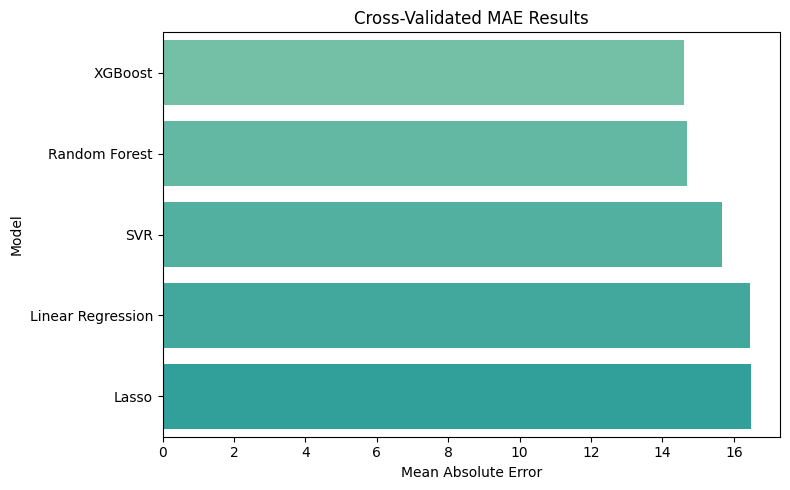

In [10]:
# Visualize the cross-validated MAE results
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="MAE (CV avg)", y="Model", palette="blend:mediumaquamarine,lightseagreen")
plt.title("Cross-Validated MAE Results")
plt.xlabel("Mean Absolute Error")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

In [11]:
# Select a random data point from the sample
test_index = np.random.randint(0, len(X_sample))
test_data = X_sample[test_index].reshape(1, -1)  # reshape for prediction
actual_value = y_sample.iloc[test_index]

# Train the XGBoost model on the entire sample
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_sample, y_sample)

predicted_value = xgb_model.predict(test_data)[0]

print(f"Actual Popularity: {actual_value}")
print(f"Predicted Popularity: {predicted_value}")

Actual Popularity: 0
Predicted Popularity: 28.164791107177734


C:\Users\sarah\AppData\Local\Temp\ipykernel_22028\583687079.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette="blend:mediumaquamarine,lightseagreen")


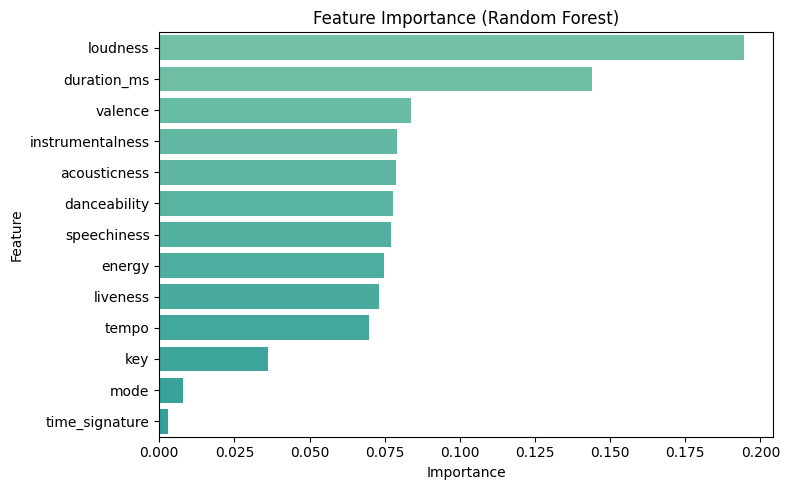

C:\Users\sarah\AppData\Local\Temp\ipykernel_22028\583687079.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette="blend:mediumaquamarine,lightseagreen")


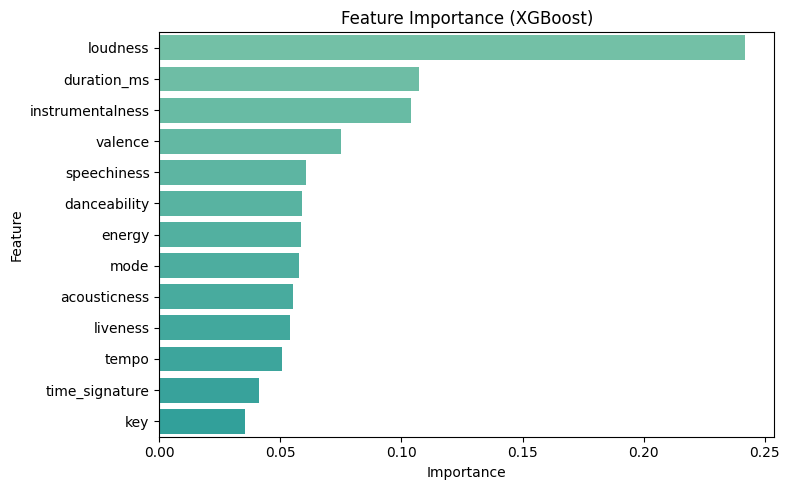

In [12]:
# Random Forest Feature Importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_sample, y_sample)
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': numerical_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette="blend:mediumaquamarine,lightseagreen")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

# XGBoost Feature Importance
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_sample, y_sample)
importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': numerical_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette="blend:mediumaquamarine,lightseagreen")
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

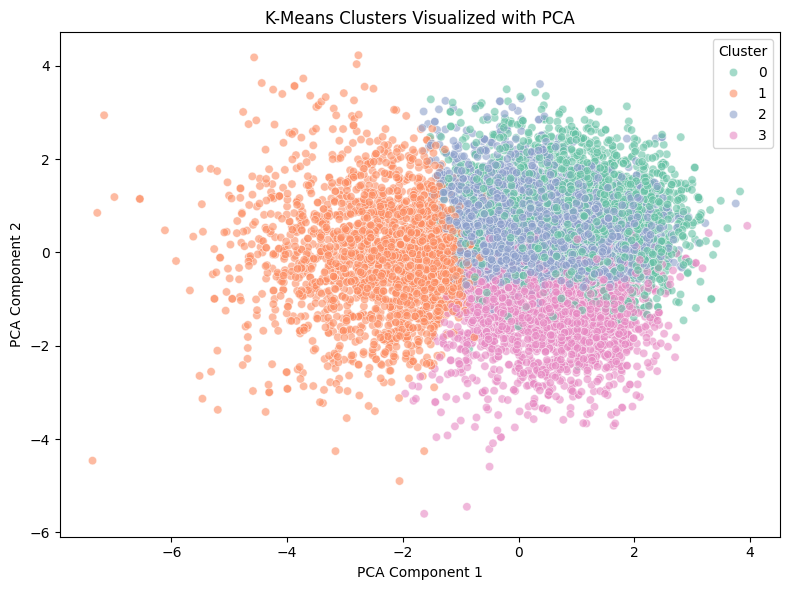

Cluster
3    41.627193
0    39.264996
2    33.181486
1    27.862852
Name: popularity, dtype: float64


C:\Users\sarah\AppData\Local\Temp\ipykernel_22028\3427802587.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_popularity.index, y=cluster_popularity.values, palette='Set2')


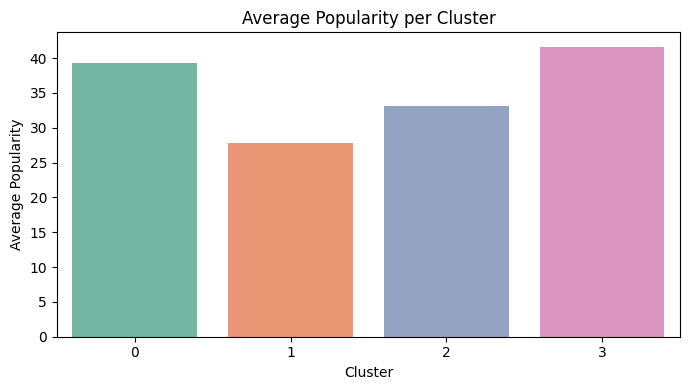

In [13]:
# K-Means clustering
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(X_sample)

# Add cluster labels to the dataframe
df_sample['Cluster'] = clusters

# Reduce to 2D with PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

df_sample['PCA1'] = X_pca[:, 0]
df_sample['PCA2'] = X_pca[:, 1]

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sample, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', alpha=0.6)
plt.title("K-Means Clusters Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Analyze cluster characteristics
cluster_popularity = df_sample.groupby('Cluster')['popularity'].mean().sort_values(ascending=False)
print(cluster_popularity)

plt.figure(figsize=(7, 4))
sns.barplot(x=cluster_popularity.index, y=cluster_popularity.values, palette='Set2')
plt.title("Average Popularity per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Popularity")
plt.tight_layout()
plt.show()

In [14]:
# Group by cluster and calculate the mean of each feature
cluster_feature_means = df_sample.groupby('Cluster')[numerical_features].mean()

# Print the feature means for each cluster
print("Feature Means by Cluster:")
print(cluster_feature_means)

Feature Means by Cluster:
           duration_ms       key      mode  time_signature  acousticness  \
Cluster                                                                    
0        245629.253357  6.324978  0.001343        3.994628      0.161721   
1        219071.888283  5.039510  0.861490        3.803361      0.575599   
2        224906.335871  4.803898  1.000000        3.996650      0.200974   
3        242190.024561  4.808333  0.914912        3.969298      0.135876   

         danceability    energy  instrumentalness  liveness   loudness  \
Cluster                                                                  
0            0.680036  0.685426          0.050326  0.175888  -8.161676   
1            0.483125  0.377939          0.079373  0.183506 -11.927112   
2            0.689405  0.656406          0.043548  0.154318  -8.849157   
3            0.514796  0.764982          0.022729  0.267353  -6.336567   

         speechiness   valence       tempo  
Cluster                    